In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Input, Add, Activation, Dense,Flatten
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import keras

In [2]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_CLASSES = 2

In [11]:
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/DATASET TRAIN'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def create_data_generators():
    print("Creating data generators...")
    train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # Rotate images by up to 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10%
    height_shift_range=0.1,  # Shift images vertically by 10%
    shear_range=0.1,  # Shear transformation
    zoom_range=[0.8, 1.2],  # Zoom in and out
    brightness_range=[0.8, 1.2],  # Adjust brightness
    horizontal_flip=False,  # Do not flip horizontally
    fill_mode='nearest',  # Fill in new pixels
    validation_split=0.2  # 20% for validation

)

    print(f"Checking training path: {train_path}")
    if not os.path.exists(train_path):
        raise ValueError(f"Training path not found: {train_path}")

    # Create generators with error handling
    try:
        train_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        validation_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        return train_generator, validation_generator

    except Exception as e:
        print(f"Error creating generators: {str(e)}")
        return None, None


In [7]:

def create_improved_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)

    # First convolution block
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Second convolution block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Third convolution block with residual connection
    shortcut = Conv2D(256, (1, 1), padding='same')(x)  # Adjust shortcut to match dimensions
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)  # This reduces the spatial dimensions
    x = Dropout(0.25)(x)

    # Adjust the shortcut to match the output shape of x
    shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)  # Adjust shortcut dimensions

    # Adding the shortcut connection
    x = Add()([x, shortcut])  # Residual connection
    x = Activation('relu')(x)

    # Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model
# Example usage
model = create_improved_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 224, 224, 64)   │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 224, 224, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 224, 224, 64)   │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 224, 224, 64)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 64)   │              0 │ activation_8[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 112, 112, 64)   │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 112, 112, 128)  │            512 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 112, 112, 128)  │            512 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 112, 112, 128)  │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 128)    │              0 │ activation_10[0][0]    │
│ (MaxPooling2D)       

 Total params: 1,380,418 (5.27 MB)

 Trainable params: 1,378,626 (5.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [8]:
def plot_training_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [9]:
import cv2
import numpy as np

def detect_nutrition_facts(image_path, model):
    # Read and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be loaded.")
        return None, 0.0, None

    img_orig = img.copy()
    img_height, img_width = img.shape[:2]

    # Convert to grayscale and apply CLAHE for contrast enhancement
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Use adaptive thresholding for better binary image
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    nutrition_box = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:  # Check for quadrilateral
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.4 <= aspect_ratio <= 3.0 and w * h > (img_height * img_width * 0.02):
                nutrition_box = approx
                break

    if nutrition_box is not None:
        cv2.drawContours(img_orig, [nutrition_box], -1, (0, 255, 0), 2)

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [nutrition_box], -1, (255), -1)
        result = cv2.bitwise_and(img_orig, img_orig, mask=mask)

        # Resize and normalize the result for the model
        result = cv2.resize(result, (IMG_WIDTH, IMG_HEIGHT))
        result = result / 255.0
        result = np.expand_dims(result, axis=0)

        # Make prediction
        prediction = model.predict(result)
        print("Raw prediction output:", prediction)
        class_index = np.argmax(prediction, axis=1)[0]
        confidence = prediction[0][class_index]  # Adjust for the predicted class

        predicted_class = 'Nutrition Fact' if class_index == 1 else 'Non Nutrition Fact'
        print(f"Detected {predicted_class} with confidence: {confidence:.2f}")

    else:
        confidence = 0.0
        predicted_class = None

    return img_orig, confidence, predicted_class

In [10]:
train_generator, validation_generator = create_data_generators()

# Check if generators were created successfully
if train_generator is not None and validation_generator is not None:
    # Create and train model
    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    print("\nData Generator Status:")
    print("Classes found:", train_generator.class_indices)
    print("Number of training samples:", train_generator.samples)
    print("Number of validation samples:", validation_generator.samples)

    # Create checkpoint callback
    checkpoint = ModelCheckpoint(
        'nutrition_model-{epoch:03d}-{val_accuracy:.4f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train model
    history = model.fit(
        train_generator,
        epochs=8,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping],
    )
    # Plot training history
    model.save('nutrition_model_final.keras')
    # Plot training history
    plot_training_history(history)
else:
    print("Failed to create data generators. Please check the error messages above.")


Creating data generators...
Checking training path: /content/drive/MyDrive/CAPSTONE


ValueError: Training path not found: /content/drive/MyDrive/CAPSTONE

In [12]:
model.save('my_model.keras')

In [13]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/my_model.keras')

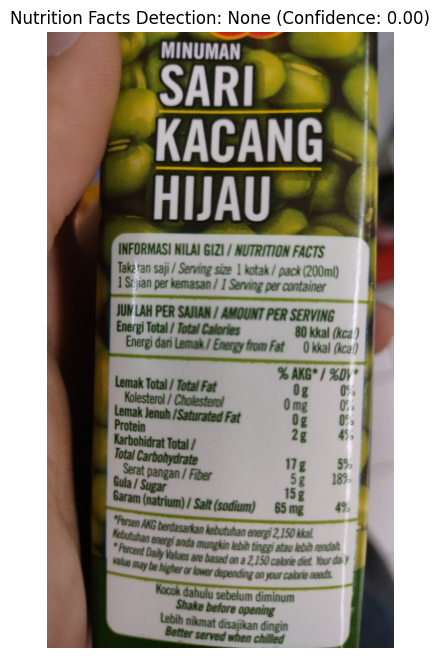

In [16]:
test_image_path = "/content/drive/MyDrive/TES/IMG20241113174041.jpg"
# Check if the image file exists
if os.path.exists(test_image_path):
    result_image, confidence, predicted_class = detect_nutrition_facts(test_image_path, loaded_model)

    # Check if the result is valid
    if result_image is not None:
        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Nutrition Facts Detection: {predicted_class} (Confidence: {confidence:.2f})')
        plt.axis('off')
        plt.show()
    else:
        print("No nutrition facts detected in the image.")
else:
    print(f"Error: The image file does not exist at the specified path: {test_image_path}")